In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os
from dotenv import load_dotenv
from census import Census
from itertools import chain
from matplotlib import pyplot as plt
from tqdm import tqdm
import contextily as cx

In [2]:
load_dotenv()
api_key = os.getenv("api_key")

# Load Census Data

In [3]:
# load relationship files
# df_tract_rel = pd.read_csv(
#     "https://www2.census.gov/geo/docs/maps-data/data/rel2020/tract/tab20_tract20_tract10_natl.txt",
#     sep="|",
# )
df_tract_rel = pd.read_csv("census_rel_file.txt", sep="|")
df_block_rel = pd.read_csv("tab2010_tab2020_st36_ny.txt")

In [4]:
# nyc_tracts = gpd.read_file(
#     "https://data.cityofnewyork.us/resource/63ge-mke6.geojson?$limit=100000"
# )
nyc_tracts = gpd.read_file("2020 Census Tracts_20250307.geojson")
nyc_tracts.head()

,shape_area,ntaname,cdtaname,shape_leng,boroname,ct2020,nta2020,borocode,cdeligibil,geoid,boroct2020,cdta2020,ctlabel,geometry
0,1843004.52241,The Battery-Governors Island-Ellis Island-Libe...,MN01 Financial District-Tribeca (CD 1 Equivalent),10833.0439286,Manhattan,000100,MN0191,1,None,36061000100,1000100,MN01,1,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ..."
1,1006116.58429,Lower East Side,MN03 Lower East Side-Chinatown (CD 3 Equivalent),5075.33199978,Manhattan,001401,MN0302,1,None,36061001401,1001401,MN03,14.01,"MULTIPOLYGON (((-73.98837 40.71645, -73.98754 ..."
2,1226206.24719,Lower East Side,MN03 Lower East Side-Chinatown (CD 3 Equivalent),4459.1560187,Manhattan,001402,MN0302,1,None,36061001402,1001402,MN03,14.02,"MULTIPOLYGON (((-73.98507 40.71908, -73.98423 ..."
3,2399276.86435,Lower East Side,MN03 Lower East Side-Chinatown (CD 3 Equivalent),6391.92117449,Manhattan,001800,MN0302,1,None,36061001800,1001800,MN03,18,"MULTIPOLYGON (((-73.98985 40.72052, -73.98972 ..."
4,1740173.87581,Lower East Side,MN03 Lower East Side-Chinatown (CD 3 Equivalent),5779.06260724,Manhattan,002201,MN0302,1,None,36061002201,1002201,MN03,22.01,"MULTIPOLYGON (((-73.97875 40.71993, -73.97879 ..."


In [5]:
# load 2010 tracts
# nyc_tracts_2010 = gpd.read_file(
#     "https://www2.census.gov/geo/tiger/TIGER2010/TRACT/2010/tl_2010_36061_tract10.zip"
# )
nyc_tracts_2010 = gpd.read_file("tl_2010_36061_tract10.zip")
nyc_tracts_2010.head()

,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
0,36,061,027100,36061027100,271,Census Tract 271,G5020,S,192555,0,+40.8519392,-073.9342905,"POLYGON ((-73.93666 40.85045, -73.93634 40.851..."
1,36,061,012900,36061012900,129,Census Tract 129,G5020,S,404996,407508,+40.7650139,-073.9998117,"POLYGON ((-74.00827 40.76485, -74.00585 40.768..."
2,36,061,014401,36061014401,144.01,Census Tract 144.01,G5020,S,74319,0,+40.7752486,-073.9475520,"POLYGON ((-73.94937 40.77688, -73.94919 40.776..."
3,36,061,009900,36061009900,99,Census Tract 99,G5020,S,1007102,1125670,+40.7523775,-074.0083669,"POLYGON ((-73.99843 40.75556, -73.99866 40.755..."
4,36,061,014601,36061014601,146.01,Census Tract 146.01,G5020,S,74328,0,+40.7771918,-073.9521610,"POLYGON ((-73.94987 40.7762, -73.95034 40.7755..."


In [6]:
# select all tracts in the east village
cb3_sectors = {
    2020: {
        1: ["004200", "004002", "004001", "003602", "003800"],
        2: ["003400", "003200", "003002"],
        3: ["002800", "002602", "002601", "002202"],
        4: ["003001", "002201"],
        5: ["001200", "001001", "001402", "001401"],
        6: ["000600", "000201", "000202"],
        7: ["000800", "002700", "002500"],
        8: ["002902", "001600"],
        9: ["001800", "003601"],
        10: ["002400", "002000", "001002"],
    },
    2010: {
        1: ["004200", "004000", "003602", "003800"],
        2: ["003400", "003200", "003002"],
        3: ["002800", "002602", "002601", "002202"],
        4: ["003001", "002201"],
        5: ["001200", "001001", "001402", "001401"],
        6: ["000600", "000201", "000202"],
        7: ["000800", "002700", "002500"],
        8: ["002900", "001600"],
        9: ["001800", "003601"],
        10: ["002400", "002000", "001002"],
    },
}

cb3_tracts = list(chain.from_iterable(cb3_sectors[2020].values()))

In [7]:
# subset rel file to CB3
df_tract_rel["GEOID_form_20"] = (
    df_tract_rel["GEOID_TRACT_20"].astype(str).str.pad(11, side="left", fillchar="0")
)
df_tract_rel["GEOID_form_10"] = (
    df_tract_rel["GEOID_TRACT_10"].astype(str).str.pad(11, side="left", fillchar="0")
)
cb3_tract_rel = df_tract_rel[
    (df_tract_rel["GEOID_form_20"].str.slice(-6).isin(cb3_tracts))
    & (df_tract_rel["GEOID_form_20"].str.slice(0, 5) == "36061")
]
cb3_tracts_2010 = cb3_tract_rel["GEOID_form_10"].str.slice(5).unique()

cb3_tracts_by_year = {2020: cb3_tracts, 2010: cb3_tracts_2010}

In [8]:
# check tracts that changed
cb3_tract_rel[cb3_tract_rel["GEOID_TRACT_20"] != cb3_tract_rel["GEOID_TRACT_10"]]

,OID_TRACT_20,GEOID_TRACT_20,NAMELSAD_TRACT_20,AREALAND_TRACT_20,AREAWATER_TRACT_20,MTFCC_TRACT_20,FUNCSTAT_TRACT_20,OID_TRACT_10,GEOID_TRACT_10,NAMELSAD_TRACT_10,AREALAND_TRACT_10,AREAWATER_TRACT_10,MTFCC_TRACT_10,FUNCSTAT_TRACT_10,AREALAND_PART,AREAWATER_PART,GEOID_form_20,GEOID_form_10
77768,2079015681794567,36061002902,Census Tract 29.02,123830,0,G5020,S,20740460864031,36061002900,Census Tract 29,273358,0,G5020,S,123830,0,36061002902,36061002900
77780,2079019627440616,36061004001,Census Tract 40.01,91742,0,G5020,S,20740460873500,36061004000,Census Tract 40,178333,0,G5020,S,91742,0,36061004001,36061004000
77781,2079015681794515,36061004002,Census Tract 40.02,86591,0,G5020,S,20740460873500,36061004000,Census Tract 40,178333,0,G5020,S,86591,0,36061004002,36061004000


In [9]:
# create a gdf of just cb3
cb3_gdf = nyc_tracts[nyc_tracts["cdta2020"] == "MN03"].copy()
print(cb3_gdf.shape[0], len(cb3_tracts))

31 31


In [10]:
# create a gdf of just cb3 for 2010
nyc_tracts_2010["ct2010"] = nyc_tracts_2010["GEOID10"].str.slice(5)
cb3_gdf_2010 = nyc_tracts_2010[nyc_tracts_2010["ct2010"].isin(cb3_tracts_by_year[2010])]
print(cb3_gdf_2010.shape[0], len(cb3_tracts_by_year[2010]))

30 30


In [11]:
cb3_gdf["sectors"] = np.select(
    [cb3_gdf["ct2020"].isin(cb3_sectors[2020][i]) for i in cb3_sectors[2020].keys()],
    list(cb3_sectors[2020].keys()),
)
cb3_gdf.head()

cb3_gdf_2010["sectors"] = np.select(
    [
        cb3_gdf_2010["ct2010"].isin(cb3_sectors[2010][i])
        for i in cb3_sectors[2010].keys()
    ],
    list(cb3_sectors[2010].keys()),
)
cb3_gdf_2010.head()

/opt/anaconda3/envs/cb3-census/lib/python3.13/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry,ct2010,sectors
10,36,061,001401,36061001401,14.01,Census Tract 14.01,G5020,S,93510,0,+40.7151603,-073.9873314,"POLYGON ((-73.98608 40.7144, -73.98716 40.7143...",001401,5
34,36,061,000201,36061000201,2.01,Census Tract 2.01,G5020,S,90205,88971,+40.7098991,-073.9855836,"POLYGON ((-73.98455 40.7095, -73.98404 40.7048...",000201,6
83,36,061,002500,36061002500,25,Census Tract 25,G5020,S,133767,107616,+40.7085998,-073.9978104,"POLYGON ((-73.996 40.7089, -73.99365 40.7047, ...",002500,7
88,36,061,002202,36061002202,22.02,Census Tract 22.02,G5020,S,56090,0,+40.7212601,-073.9811422,"POLYGON ((-73.97875 40.71993, -73.97973 40.720...",002202,3
98,36,061,003400,36061003400,34,Census Tract 34,G5020,S,160257,0,+40.7290092,-073.9814618,"POLYGON ((-73.978 40.72943, -73.97854 40.72875...",003400,2


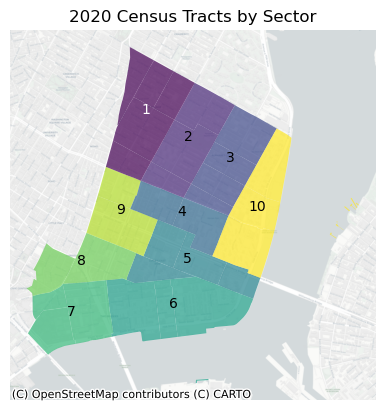

In [12]:
# create sector map
cb3_gdf = cb3_gdf.to_crs(2263)
cb3_gdf_diss = cb3_gdf.dissolve(by="sectors").to_crs(2263).reset_index()
cb3_gdf_diss["coords"] = cb3_gdf_diss["geometry"].centroid.apply(lambda x: x.coords[0])
ax = cb3_gdf.plot(column="sectors", alpha=0.7)
for idx, row in cb3_gdf_diss.iterrows():
    color = "black"
    if row["sectors"] == 1:
        color = "white"
    plt.annotate(
        text=row["sectors"], xy=row["coords"], horizontalalignment="center", color=color
    )
cx.add_basemap(ax, zoom=16, crs=cb3_gdf_diss.crs, source=cx.providers.CartoDB.Positron)
plt.title("2020 Census Tracts by Sector")
ax.set_axis_off();

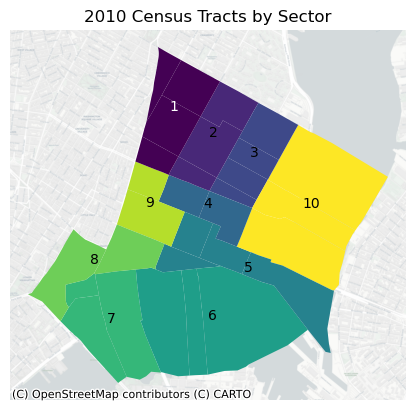

In [13]:
# create sector map
cb3_gdf_2010 = cb3_gdf_2010.to_crs(2263)
cb3_gdf_2010_diss = cb3_gdf_2010.dissolve(by="sectors").reset_index()
cb3_gdf_2010_diss["coords"] = cb3_gdf_2010_diss["geometry"].centroid.apply(
    lambda x: x.coords[0]
)
ax = cb3_gdf_2010.plot(column="sectors")
for idx, row in cb3_gdf_2010_diss.iterrows():
    color = "black"
    if row["sectors"] == 1:
        color = "white"
    plt.annotate(
        text=row["sectors"], xy=row["coords"], horizontalalignment="center", color=color
    )
cx.add_basemap(ax, zoom=16, crs=cb3_gdf_diss.crs, source=cx.providers.CartoDB.Positron)
plt.title("2010 Census Tracts by Sector")
ax.set_axis_off();

## Load Census Data

In [14]:
census = Census(api_key)

In [15]:
# dec columns
dec_dict = {
    2020: {
        "P1_001N": "total",
        "P2_002N": "hispanic_latino",
        "P2_005N": "nh_white",
        "P2_006N": "nh_black",
        "P2_007N": "nh_aian",
        "P2_008N": "nh_asian",
        "P2_009N": "nh_nhpi",
        "P2_010N": "nh_other",
        "P2_011N": "nh_multi",
    },
    2010: {
        "P001001": "total",
        "P002002": "hispanic_latino",
        "P002005": "nh_white",
        "P002006": "nh_black",
        "P002007": "nh_aian",
        "P002008": "nh_asian",
        "P002009": "nh_nhpi",
        "P002010": "nh_other",
        "P002011": "nh_multi",
    },
    2000: {
        "PL001001": "total",
        "PL002002": "hispanic_latino",
        "PL002005": "nh_white",
        "PL002006": "nh_black",
        "PL002007": "nh_aian",
        "PL002008": "nh_asian",
        "PL002009": "nh_nhpi",
        "PL002010": "nh_other",
        "PL002011": "nh_multi",
    },
}

In [16]:
# get 2020,2010 census data
dec_gdf_list = []
for yr in [2020, 2010]:
    print(yr)
    dec_gdf_yr = census.pl.get(
        (["NAME", "GEO_ID"] + list(dec_dict[yr].keys())),
        geo={
            "for": f"tract:{','.join(cb3_tracts)}",
            "in": f"state:36 county:061",
        },
        year=yr,
    )
    dec_gdf_list += [
        pd.DataFrame(dec_gdf_yr).rename(columns=dec_dict[yr]).assign(year=yr)
    ]
dec_gdf = pd.concat(dec_gdf_list)
dec_gdf.head()

2020
2010


,NAME,GEO_ID,total,hispanic_latino,nh_white,nh_black,nh_aian,nh_asian,nh_nhpi,nh_other,nh_multi,state,county,tract,year
0,"Census Tract 2.01, New York County, New York",1400000US36061000201,2012.0,784.0,221.0,244.0,0.0,702.0,0.0,11.0,50.0,36,061,000201,2020
1,"Census Tract 2.02, New York County, New York",1400000US36061000202,7266.0,2683.0,1575.0,942.0,12.0,1832.0,0.0,55.0,167.0,36,061,000202,2020
2,"Census Tract 6, New York County, New York",1400000US36061000600,11616.0,2946.0,1145.0,1227.0,16.0,6027.0,6.0,42.0,207.0,36,061,000600,2020
3,"Census Tract 8, New York County, New York",1400000US36061000800,10871.0,532.0,1233.0,228.0,4.0,8708.0,5.0,53.0,108.0,36,061,000800,2020
4,"Census Tract 10.01, New York County, New York",1400000US36061001001,1767.0,259.0,1085.0,49.0,0.0,272.0,0.0,29.0,73.0,36,061,001001,2020


In [17]:
cb3_gdf_concat = pd.concat(
    [
        cb3_gdf_2010[["ct2010", "geometry", "sectors"]]
        .rename(columns={"ct2010": "ct"})
        .to_crs(2263)
        .assign(yr=2010),
        cb3_gdf[["ct2020", "geometry", "sectors"]]
        .rename(columns={"ct2020": "ct"})
        .to_crs(2263)
        .assign(yr=2020),
    ]
)

In [18]:
cb3_gdf_diss_concat = pd.concat(
    [
        cb3_gdf_diss[["sectors", "geometry"]].to_crs(2263).assign(year=2010),
        cb3_gdf_diss[["sectors", "geometry"]].to_crs(2263).assign(year=2020),
    ]
)

In [19]:
demo_cols = list(dec_dict[2020].values())
cb3_gdf_demo = cb3_gdf_concat.merge(
    dec_gdf, left_on=["ct", "yr"], right_on=["tract", "year"], how="outer"
)
cb3_gdf_demo[demo_cols] = cb3_gdf_demo[demo_cols].astype(float)
cb3_gdf_sector = (
    cb3_gdf_demo.groupby(["sectors", "year"], as_index=False)[
        list(dec_dict[2020].values())
    ]
    .sum()
    .merge(cb3_gdf_diss_concat, how="right", on=["sectors", "year"])
)
cb3_gdf_sector = gpd.GeoDataFrame(cb3_gdf_sector, geometry="geometry")
cb3_gdf_sector.head()

,sectors,year,total,hispanic_latino,nh_white,nh_black,nh_aian,nh_asian,nh_nhpi,nh_other,nh_multi,geometry
0,1,2010.0,17533.0,1901.0,11146.0,863.0,37.0,2979.0,9.0,64.0,534.0,"POLYGON ((987539.574 202934.953, 987528.433 20..."
1,2,2010.0,17952.0,2734.0,11645.0,640.0,20.0,2389.0,10.0,72.0,442.0,"POLYGON ((988839.196 202327.974, 988769.575 20..."
2,3,2010.0,17302.0,6000.0,6523.0,1890.0,30.0,2379.0,5.0,74.0,401.0,"POLYGON ((990247.174 201769.415, 990219.978 20..."
3,4,2010.0,10890.0,3783.0,3381.0,894.0,29.0,2558.0,4.0,35.0,206.0,"POLYGON ((990129.82 201543.728, 990050.505 201..."
4,5,2010.0,10618.0,2677.0,5540.0,375.0,11.0,1761.0,1.0,30.0,223.0,"POLYGON ((991128.212 199590.443, 991121.187 19..."


In [20]:
# totals for cb3
cb3_totals = (
    cb3_gdf_sector.sort_values("year").groupby("year")[demo_cols].sum().reset_index()
)
cb3_totals[demo_cols].pct_change()

for col in demo_cols:
    if col != "total":
        cb3_gdf_sector[col + "_per"] = cb3_gdf_sector[col] / cb3_gdf_sector["total"]
        cb3_totals[col + "_per"] = cb3_totals[col] / cb3_totals["total"]

In [21]:
cb3_gdf_sector_srtd = cb3_gdf_sector.sort_values(["sectors", "year"])
cb3_gdf_pct_change = (
    cb3_gdf_sector_srtd.groupby("sectors")[demo_cols].pct_change() * 100
)
cb3_gdf_pct_change = cb3_gdf_sector_srtd[["sectors", "year"]].join(cb3_gdf_pct_change)
cb3_gdf_pct_change = cb3_gdf_pct_change[cb3_gdf_pct_change["total"].notna()]
cb3_gdf_pct_change = (
    cb3_gdf_diss[["sectors", "geometry"]]
    .to_crs(2263)
    .merge(cb3_gdf_pct_change, how="right", on="sectors")
)
cb3_gdf_pct_change.head()

,sectors,geometry,year,total,hispanic_latino,nh_white,nh_black,nh_aian,nh_asian,nh_nhpi,nh_other,nh_multi
0,1,"POLYGON ((987539.574 202934.953, 987528.433 20...",2020.0,48.970513,59.915834,44.643818,40.787949,-51.351351,43.235985,122.222222,242.187500,128.089888
1,2,"POLYGON ((988839.196 202327.974, 988769.575 20...",2020.0,2.601381,2.340892,-0.145985,-3.125000,180.000000,-0.460444,110.000000,112.500000,73.076923
2,3,"POLYGON ((990247.174 201769.415, 990219.978 20...",2020.0,2.485262,-8.166667,7.297256,-8.359788,-43.333333,12.610340,140.000000,109.459459,56.608479
3,4,"POLYGON ((990129.82 201543.728, 990050.505 201...",2020.0,6.813590,-4.890299,24.341911,7.829978,-65.517241,-6.372166,-50.000000,100.000000,88.834951
4,5,"POLYGON ((991128.212 199590.443, 991121.187 19...",2020.0,17.762290,3.660814,5.180505,44.533333,18.181818,52.129472,0.000000,373.333333,135.426009


In [22]:
cb3_gdf_pct_change.to_file(
    "_output_data/cb3_decennial_pctchange.geojson", driver="GeoJSON"
)

/opt/anaconda3/envs/cb3-census/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: NaN of Infinity value found. Skipped
  ogr_write(


In [23]:
# define columns for plots
demo_cols_per = [x + "_per" for x in demo_cols if x != "total"]

race_cols_per = [
    x + "_per" for x in ["hispanic_latino", "nh_white", "nh_black", "nh_asian"]
]

In [24]:
cb3_gdf_long = (
    pd.concat([cb3_gdf_sector, cb3_totals.assign(sectors="total")])
    .melt(id_vars=["sectors", "year"], value_vars=demo_cols + demo_cols_per)
    .pivot(columns=["year"], index=["sectors", "variable"], values="value")
)
cb3_gdf_long.head()

cb3_gdf_long["diff"] = cb3_gdf_long[2020] - cb3_gdf_long[2010]
cb3_gdf_long["pct_change"] = (cb3_gdf_long[2020] - cb3_gdf_long[2010]) / cb3_gdf_long[
    2010
]

cb3_gdf_long = (
    cb3_gdf_long.reset_index()
    .pivot(
        index=["variable"],
        columns=["sectors"],
        values=[2010, 2020, "diff", "pct_change"],
    )
    .swaplevel(axis=1)
    .sort_index(axis=1, level=[0, 1], ascending=[True, True])
)
cb3_gdf_long

sectors                         1                                        \
                             2010          2020         diff pct_change   
variable                                                                  
hispanic_latino       1901.000000   3040.000000  1139.000000   0.599158   
hispanic_latino_per      0.108424      0.116390     0.007966   0.073473   
nh_aian                 37.000000     18.000000   -19.000000  -0.513514   
nh_aian_per              0.002110      0.000689    -0.001421  -0.673434   
nh_asian              2979.000000   4267.000000  1288.000000   0.432360   
nh_asian_per             0.169908      0.163368    -0.006541  -0.038494   
nh_black               863.000000   1215.000000   352.000000   0.407879   
nh_black_per             0.049221      0.046518    -0.002704  -0.054927   
nh_multi               534.000000   1218.000000   684.000000   1.280899   
nh_multi_per             0.030457      0.046633     0.016176   0.531108   
nh_nhpi                  9.000000     20.000000    11.000000   1.222222   
nh_nhpi_per              0.000513      0.000766     0.000252   0.491720   
nh_other                64.000000    219.000000   155.000000   2.421875   
nh_other_per             0.003650      0.008385     0.004734   1.297015   
nh_white             11146.000000  16122.000000  4976.000000   0.446438   
nh_white_per             0.635716      0.617252    -0.018464  -0.029044   
total                17533.000000  26119.000000  8586.000000   0.489705   

sectors                         2                                       \
                             2010          2020        diff pct_change   
variable                                                                 
hispanic_latino       2734.000000   2798.000000   64.000000   0.023409   
hispanic_latino_per      0.152295      0.151908   -0.000387  -0.002539   
nh_aian                 20.000000     56.000000   36.000000   1.800000   
nh_aian_per              0.001114      0.003040    0.001926   1.729008   
nh_asian              2389.000000   2378.000000  -11.000000  -0.004604   
nh_asian_per             0.133077      0.129106   -0.003971  -0.029842   
nh_black               640.000000    620.000000  -20.000000  -0.031250   
nh_black_per             0.035651      0.033661   -0.001990  -0.055812   
nh_multi               442.000000    765.000000  323.000000   0.730769   
nh_multi_per             0.024621      0.041533    0.016912   0.686887   
nh_nhpi                 10.000000     21.000000   11.000000   1.100000   
nh_nhpi_per              0.000557      0.001140    0.000583   1.046756   
nh_other                72.000000    153.000000   81.000000   1.125000   
nh_other_per             0.004011      0.008307    0.004296   1.071122   
nh_white             11645.000000  11628.000000  -17.000000  -0.001460   
nh_white_per             0.648674      0.631305   -0.017370  -0.026777   
total                17952.000000  18419.000000  467.000000   0.026014   

sectors                         3                ...            9             \
                             2010          2020  ...         diff pct_change   
variable                                         ...                           
hispanic_latino       6000.000000   5510.000000  ...    12.000000   0.005206   
hispanic_latino_per      0.346781      0.310738  ...     0.011172   0.058421   
nh_aian                 30.000000     17.000000  ...    -6.000000  -0.375000   
nh_aian_per              0.001734      0.000959  ...    -0.000454  -0.341913   
nh_asian              2379.000000   2679.000000  ... -1789.000000  -0.292799   
nh_asian_per             0.137499      0.151083  ...    -0.129449  -0.255360   
nh_black              1890.000000   1732.000000  ...   225.000000   0.393357   
nh_black_per             0.109236      0.097677  ...     0.022168   0.467120   
nh_multi               401.000000    628.000000  ...   113.000000   0.556650   
nh_multi_per             0.023177      0.035416  ...     0

In [25]:
cb3_gdf_unstack = cb3_gdf_long.unstack().reset_index()
cb3_gdf_unstack["varname_full"] = (
    cb3_gdf_unstack["variable"] + "_" + cb3_gdf_unstack["level_1"].astype(str)
)
cb3_gdf_over_time = cb3_gdf_unstack.pivot(
    columns="varname_full", values=0, index="sectors"
).reset_index()
change_cols = [
    x
    for x in cb3_gdf_over_time.columns
    if x.endswith("diff") | x.endswith("pct_change")
]
cb3_gdf_over_time.head()

varname_full,sectors,hispanic_latino_2010,hispanic_latino_2020,hispanic_latino_diff,hispanic_latino_pct_change,hispanic_latino_per_2010,hispanic_latino_per_2020,hispanic_latino_per_diff,hispanic_latino_per_pct_change,nh_aian_2010,...,nh_white_diff,nh_white_pct_change,nh_white_per_2010,nh_white_per_2020,nh_white_per_diff,nh_white_per_pct_change,total_2010,total_2020,total_diff,total_pct_change
0,1,1901.0,3040.0,1139.0,0.599158,0.108424,0.116390,0.007966,0.073473,37.0,...,4976.0,0.446438,0.635716,0.617252,-0.018464,-0.029044,17533.0,26119.0,8586.0,0.489705
1,2,2734.0,2798.0,64.0,0.023409,0.152295,0.151908,-0.000387,-0.002539,20.0,...,-17.0,-0.001460,0.648674,0.631305,-0.017370,-0.026777,17952.0,18419.0,467.0,0.026014
2,3,6000.0,5510.0,-490.0,-0.081667,0.346781,0.310738,-0.036043,-0.103936,30.0,...,476.0,0.072973,0.377008,0.394710,0.017702,0.046953,17302.0,17732.0,430.0,0.024853
3,4,3783.0,3598.0,-185.0,-0.048903,0.347383,0.309319,-0.038064,-0.109573,29.0,...,823.0,0.243419,0.310468,0.361417,0.050948,0.164102,10890.0,11632.0,742.0,0.068136
4,5,2677.0,2775.0,98.0,0.036608,0.252119,0.221929,-0.030190,-0.119745,11.0,...,287.0,0.051805,0.521756,0.466011,-0.055745,-0.106841,10618.0,12504.0,1886.0,0.177623


In [26]:
# write to excel
workbook = pd.ExcelWriter("cb3_decennial_census.xlsx", engine="xlsxwriter")

cb3_gdf_sector.sort_values(["sectors", "year"]).to_excel(
    workbook, sheet_name="Overall Percentage", index=False
)
cb3_gdf_pct_change.to_excel(workbook, sheet_name="% Change", index=False)
cb3_gdf_long.to_excel(workbook, sheet_name="Long Format", index=True)

# workbook.save()
workbook.close()

In [27]:
cb3_gdf_sector[cb3_gdf_sector["year"] == 2010].to_file(
    "_output_data/cb3_decennial.geojson", driver="GeoJSON"
)
cb3_gdf_sector[cb3_gdf_sector["year"] == 2020].merge(
    cb3_gdf_over_time[change_cols + ["sectors"]], on="sectors", how="left"
).to_file("_output_data/cb3_decennial_2020.geojson", driver="GeoJSON")

In [28]:
cb3_gdf_over_time[change_cols + ["sectors"]]

varname_full,hispanic_latino_diff,hispanic_latino_pct_change,hispanic_latino_per_diff,hispanic_latino_per_pct_change,nh_aian_diff,nh_aian_pct_change,nh_aian_per_diff,nh_aian_per_pct_change,nh_asian_diff,nh_asian_pct_change,...,nh_other_pct_change,nh_other_per_diff,nh_other_per_pct_change,nh_white_diff,nh_white_pct_change,nh_white_per_diff,nh_white_per_pct_change,total_diff,total_pct_change,sectors
0,1139.0,0.599158,0.007966,0.073473,-19.0,-0.513514,-0.001421,-0.673434,1288.0,0.432360,...,2.421875,0.004734,1.297015,4976.0,0.446438,-0.018464,-0.029044,8586.0,0.489705,1
1,64.0,0.023409,-0.000387,-0.002539,36.0,1.800000,0.001926,1.729008,-11.0,-0.004604,...,1.125000,0.004296,1.071122,-17.0,-0.001460,-0.017370,-0.026777,467.0,0.026014,2
2,-490.0,-0.081667,-0.036043,-0.103936,-13.0,-0.433333,-0.000775,-0.447075,300.0,0.126103,...,1.094595,0.004464,1.043801,476.0,0.072973,0.017702,0.046953,430.0,0.024853,3
3,-185.0,-0.048903,-0.038064,-0.109573,-19.0,-0.655172,-0.001803,-0.677169,-163.0,-0.063722,...,1.000000,0.002804,0.872421,823.0,0.243419,0.050948,0.164102,742.0,0.068136,4
4,98.0,0.036608,-0.030190,-0.119745,2.0,0.181818,0.000004,0.003562,918.0,0.521295,...,3.733333,0.008531,3.019396,287.0,0.051805,-0.055745,-0.106841,1886.0,0.177623,5
5,-233.0,-0.035059,0.001241,0.004058,-2.0,-0.066667,-0.000040,-0.028831,-1549.0,-0.153215,...,2.176471,0.003605,2.305238,328.0,0.125526,0.020570,0.171153,-847.0,-0.038959,6
6,110.0,0.048780,0.002874,0.020931,1.0,0.100000,0.000043,0.070790,-459.0,-0.038436,...,5.428571,0.004482,5.257864,367.0,0.309966,0.019839,0.275181,448.0,0.027279,7
7,327.0,1.189091,0.017493,0.539281,4.0,1.333333,0.000227,0.640707,1928.0,0.273980,...,4.375000,0.002623,2.779485,916.0,0.928065,0.041415,0.355738,3579.0,0.422151,8
8,12.0,0.005206,0.011172,0.058421,-6.0,-0.375000,-0.000454,-0.341913,-1789.0,-0.292799,...,3.894737,0.006548,4.153862,753.0,0.266266,0.078203,0.333302,-606.0,-0.050278,9
9,-1505.0,-0.139935,-0.038380,-0.060301,-35.0,-0.744681,-0.002005,-0.721041,87.0,0.036662,...,1.194444,0.002978,1.397628,-344.0,-0.540881,-0.018757,-0.498371,-1432.0,-0.084744,10


In [29]:
cb3_gdf_sector[cb3_gdf_sector["year"] == 2020].merge(
    cb3_gdf_over_time[change_cols + ["sectors"]], on="sectors", how="left"
)

,sectors,year,total,hispanic_latino,nh_white,nh_black,nh_aian,nh_asian,nh_nhpi,nh_other,...,nh_other_diff,nh_other_pct_change,nh_other_per_diff,nh_other_per_pct_change,nh_white_diff,nh_white_pct_change,nh_white_per_diff,nh_white_per_pct_change,total_diff,total_pct_change
0,1,2020.0,26119.0,3040.0,16122.0,1215.0,18.0,4267.0,20.0,219.0,...,155.0,2.421875,0.004734,1.297015,4976.0,0.446438,-0.018464,-0.029044,8586.0,0.489705
1,2,2020.0,18419.0,2798.0,11628.0,620.0,56.0,2378.0,21.0,153.0,...,81.0,1.125000,0.004296,1.071122,-17.0,-0.001460,-0.017370,-0.026777,467.0,0.026014
2,3,2020.0,17732.0,5510.0,6999.0,1732.0,17.0,2679.0,12.0,155.0,...,81.0,1.094595,0.004464,1.043801,476.0,0.072973,0.017702,0.046953,430.0,0.024853
3,4,2020.0,11632.0,3598.0,4204.0,964.0,10.0,2395.0,2.0,70.0,...,35.0,1.000000,0.002804,0.872421,823.0,0.243419,0.050948,0.164102,742.0,0.068136
4,5,2020.0,12504.0,2775.0,5827.0,542.0,13.0,2679.0,1.0,142.0,...,112.0,3.733333,0.008531,3.019396,287.0,0.051805,-0.055745,-0.106841,1886.0,0.177623
5,6,2020.0,20894.0,6413.0,2941.0,2413.0,28.0,8561.0,6.0,108.0,...,74.0,2.176471,0.003605,2.305238,328.0,0.125526,0.020570,0.171153,-847.0,-0.038959
6,7,2020.0,16871.0,2365.0,1551.0,1129.0,11.0,11483.0,12.0,90.0,...,76.0,5.428571,0.004482,5.257864,367.0,0.309966,0.019839,0.275181,448.0,0.027279
7,8,2020.0,12057.0,602.0,1903.0,258.0,7.0,8965.0,1.0,43.0,...,35.0,4.375000,0.002623,2.779485,916.0,0.928065,0.041415,0.355738,3579.0,0.422151
8,9,2020.0,11447.0,2317.0,3581.0,797.0,10.0,4321.0,12.0,93.0,...,74.0,3.894737,0.006548,4.153862,753.0,0.266266,0.078203,0.333302,-606.0,-0.050278
9,10,2020.0,15466.0,9250.0,292.0,3106.0,12.0,2460.0,4.0,79.0,...,43.0,1.194444,0.002978,1.397628,-344.0,-0.540881,-0.018757,-0.498371,-1432.0,-0.084744


In [30]:
# cb3_gdf_sector["coords"] = cb3_gdf_sector["geometry"].centroid.apply(
#     lambda x: x.coords[0]
# )
# cb3_gdf_sector["total_cat"], total_labs = pd.cut(
#     cb3_gdf_sector["total"], 5, retbins=True, include_lowest=True
# )
# # cb3_gdf_sector['total_cat'] = cb3_gdf_sector['total_cat'].astype(str)
# fig, axes = plt.subplots(2, 1, figsize=(6, 8))

# yrs = [2010, 2020]
# for j in range(2):
#     cb3_gdf_sector[cb3_gdf_sector["year"] == yrs[j]].plot(
#         ax=axes[j],
#         column="total_cat",
#         cmap="YlOrRd",
#         categorical=True,
#         legend=True,
#         legend_kwds={"loc": "center left", "bbox_to_anchor": (1, 0.5), "fmt": "{:.0f}"},
#     )

#     axes[j].set_title(f"Total pop")
#     axes[j].set_xticks([])
#     axes[j].set_yticks([])
#     axes[j].spines["top"].set_visible(False)
#     axes[j].spines["right"].set_visible(False)
#     axes[j].spines["bottom"].set_visible(False)
#     axes[j].spines["left"].set_visible(False)

#     for idx, row in cb3_gdf_sector[cb3_gdf_sector["year"] == yrs[j]].iterrows():
#         axes[j].annotate(
#             text=f'{round(row["total"]):,}',
#             xy=row["coords"],
#             horizontalalignment="center",
#             color="white",
#             size=5,
#         )
#     cx.add_basemap(
#         axes[j], zoom=17, crs=cb3_gdf_sector.crs, source=cx.providers.CartoDB.Positron
#     )

#     # assume it's the first (and only) mappable
#     # patch_col = axes[j].collections[0]
#     # cb = fig.colorbar(patch_col, ax=axes[j], shrink=0.5)

#     # for ax, row in zip(axes[:], [2010, 2020]):
#     #     ax.set_ylabel(row, rotation=0, size="large")
# plt.savefig("cb3_maps_total.pdf", dpi=300);

In [31]:
# fig, axes = plt.subplots(2, 4, figsize=(24, 8))

# yrs = [2010, 2020]
# for j in range(2):
#     for i in range(len(race_cols_per)):
#         cb3_gdf_sector[race_cols_per[i] + "_cat"], total_labs = pd.qcut(
#             cb3_gdf_sector[race_cols_per[i]], 5, retbins=True
#         )
#         cb3_gdf_sector[cb3_gdf_sector["year"] == yrs[j]].plot(
#             ax=axes[j, i],
#             column=race_cols_per[i] + "_cat",
#             categorical=True,
#             legend=True,
#             cmap="YlOrRd",
#             legend_kwds={
#                 "loc": "center left",
#                 "bbox_to_anchor": (1, 0.5),
#                 "fmt": "{:.0f}",
#             },
#         )
#         axes[j, i].set_title(f"{race_cols_per[i].replace('_', ' ').replace('per','')}")
#         # axes[j,i].set_axis_off()
#         axes[j, i].set_xticks([])
#         axes[j, i].set_yticks([])
#         axes[j, i].spines["top"].set_visible(False)
#         axes[j, i].spines["right"].set_visible(False)
#         axes[j, i].spines["bottom"].set_visible(False)
#         axes[j, i].spines["left"].set_visible(False)
#         cx.add_basemap(
#             axes[j, i],
#             zoom=17,
#             crs=cb3_gdf_sector.crs,
#             source=cx.providers.CartoDB.Positron,
#         )

#         for idx, row in cb3_gdf_sector[cb3_gdf_sector["year"] == yrs[j]].iterrows():
#             axes[j, i].annotate(
#                 text=f"{round(row[race_cols_per[i]]*100)}%",
#                 xy=row["coords"],
#                 horizontalalignment="center",
#                 color="white",
#             )
# # assume it's the first (and only) mappable
# # patch_col = axes[0, 0].collections[0]
# # cb = fig.colorbar(patch_col, ax=axes, shrink=0.5)

# for ax, row in zip(axes[:, 0], [2010, 2020]):
#     ax.set_ylabel(row, rotation=0, size="large")
# plt.savefig("cb3_maps.pdf", dpi=300);

In [32]:
race_cols = ["hispanic_latino", "nh_white", "nh_black", "nh_asian"]
cb3_gdf_pct_change_long = cb3_gdf_pct_change.melt(
    id_vars="sectors", value_vars=race_cols
)
cb3_gdf_pct_change_long["value_cat"], total_labs = pd.qcut(
    cb3_gdf_pct_change_long["value"], 5, retbins=True
)
cb3_gdf_pct_change_wide = cb3_gdf_pct_change_long.pivot(
    values=["value", "value_cat"], columns="variable", index="sectors"
)

In [33]:
cb3_gdf_pct_change.to_file(
    "_output_data/cb3_decennial_pctchange.geojson", driver="GeoJSON"
)

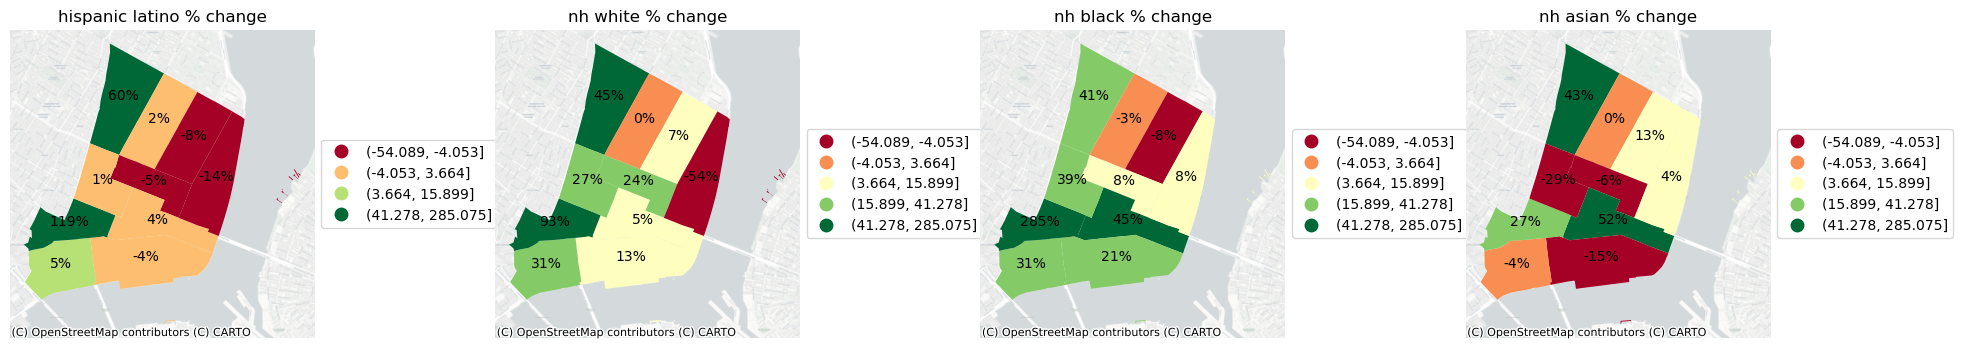

In [34]:
cb3_gdf_diss = cb3_gdf_diss.to_crs(2263)
cb3_gdf_pct_change_cat = cb3_gdf_pct_change[["sectors", "geometry"]].merge(
    cb3_gdf_pct_change_wide["value_cat"].reset_index(), on="sectors"
)
cb3_gdf_pct_change_cont = cb3_gdf_pct_change[["sectors", "geometry"]].merge(
    cb3_gdf_pct_change_wide["value"].reset_index(), on="sectors"
)

cb3_gdf_pct_change_cont["coords"] = cb3_gdf_pct_change_cont["geometry"].centroid.apply(
    lambda x: x.coords[0]
)
fig, axes = plt.subplots(1, 4, figsize=(24, 4))

for i in range(len(race_cols)):
    cb3_gdf_pct_change_cat.plot(
        ax=axes[i],
        column=race_cols[i],
        legend=True,
        categorical=True,
        cmap="RdYlGn",
        legend_kwds={"loc": "center left", "bbox_to_anchor": (1, 0.5), "fmt": "{:.0f}"},
    )
    # cb3_gdf_diss.plot(ax=axes[i], facecolor='none')
    for idx, row in cb3_gdf_pct_change_cont.iterrows():
        axes[i].annotate(
            text=f"{round(row[race_cols[i]])}%",
            xy=row["coords"],
            horizontalalignment="center",
            color="black",
        )

    cx.add_basemap(
        axes[i], zoom=16, crs=cb3_gdf_diss.crs, source=cx.providers.CartoDB.Positron
    )
    axes[i].set_title(f"{race_cols_per[i].replace('_', ' ').replace('per','% change')}")
    axes[i].set_axis_off()
# assume it's the first (and only) mappable
# patch_col = axes[0].collections[0]
# cb = fig.colorbar(patch_col, ax=axes, shrink=0.5)
plt.savefig("cb3_maps_pct_change.pdf");

## ACS Data

In [35]:
# load acs dict
acs_dict = pd.read_excel("acs_dict.xlsx").set_index("colname").to_dict()["textname"]

In [36]:
acs_dict_denom = pd.read_excel("acs_dict.xlsx").set_index("denom_col")
acs_dict_denom = acs_dict_denom[acs_dict_denom.index.notna()]
acs_dict_denom_dict = {
    u: acs_dict_denom.loc[u, "textname"].tolist() for u in acs_dict_denom.index.unique()
}

In [37]:
acs_table = pd.read_excel("acs_dict.xlsx").set_index("table_name")
acs_table = acs_table[acs_table.index.notna()]
acs_table["pct_col"] = np.where(
    acs_table["denom_col"].notna(), acs_table["textname"] + "_pct", ""
)
acs_dict_table = {
    u: acs_table.loc[u, "textname"].tolist() for u in acs_table.index.unique()
}

acs_table_pct = acs_table.loc[acs_table["pct_col"] != ""]
acs_pct_dict_table = {
    u: acs_table_pct.loc[u, "pct_col"].tolist() for u in acs_table_pct.index.unique()
}

In [38]:
acs_gdf = [
    pd.DataFrame(
        census.acs5.get(
            (tuple(["NAME", "GEO_ID"] + list(acs_dict.keys()))),
            geo={
                "for": f"tract:{','.join(cb3_tracts)}",
                "in": f"state:36 county:061",
            },
            year=yr,
        )
    ).assign(year=yr)
    for yr in tqdm([2018, 2020, 2023])
]

100%|██████████| 3/3 [02:03<00:00, 41.15s/it]


In [39]:
[x for x in acs_dict.keys() if ~(x.startswith("B05002"))]

/var/folders/_q/g5l2s5950hz1zr9syt43gzp80000gn/T/ipykernel_39279/3408160613.py:1: DeprecationWarning: Bitwise inversion '~' on bool is deprecated and will be removed in Python 3.16. This returns the bitwise inversion of the underlying int object and is usually not what you expect from negating a bool. Use the 'not' operator for boolean negation or ~int(x) if you really want the bitwise inversion of the underlying int.
  [x for x in acs_dict.keys() if ~(x.startswith('B05002'))]


['B01001_001E',
 'B01001_002E',
 'B01001_003E',
 'B01001_004E',
 'B01001_005E',
 'B01001_006E',
 'B01001_007E',
 'B01001_008E',
 'B01001_009E',
 'B01001_010E',
 'B01001_011E',
 'B01001_012E',
 'B01001_013E',
 'B01001_014E',
 'B01001_015E',
 'B01001_016E',
 'B01001_017E',
 'B01001_018E',
 'B01001_019E',
 'B01001_020E',
 'B01001_021E',
 'B01001_022E',
 'B01001_023E',
 'B01001_024E',
 'B01001_025E',
 'B01001_026E',
 'B01001_027E',
 'B01001_028E',
 'B01001_029E',
 'B01001_030E',
 'B01001_031E',
 'B01001_032E',
 'B01001_033E',
 'B01001_034E',
 'B01001_035E',
 'B01001_036E',
 'B01001_037E',
 'B01001_038E',
 'B01001_039E',
 'B01001_040E',
 'B01001_041E',
 'B01001_042E',
 'B01001_043E',
 'B01001_044E',
 'B01001_045E',
 'B01001_046E',
 'B01001_047E',
 'B01001_048E',
 'B01001_049E',
 'B01002_001E',
 'B01002_002E',
 'B01002_003E',
 'B02001_001E',
 'B02001_002E',
 'B02001_003E',
 'B02001_004E',
 'B02001_005E',
 'B02001_006E',
 'B02001_007E',
 'B02001_008E',
 'B03002_001E',
 'B03002_002E',
 'B03002

In [40]:
acs_gdf_2013 = [
    pd.DataFrame(
        census.acs5.get(
            (
                tuple(
                    ["NAME", "GEO_ID"]
                    + [x for x in acs_dict.keys() if not (x.startswith("B05002"))]
                )
            ),
            geo={
                "for": f"tract:{','.join(cb3_tracts)}",
                "in": f"state:36 county:061",
            },
            year=yr,
        )
    ).assign(year=2013)
]

In [41]:
acs_gdf_clean = pd.concat(acs_gdf + acs_gdf_2013).rename(columns=acs_dict)
acs_gdf_clean = acs_gdf_clean[acs_gdf_clean["year"].isin([2013, 2018, 2023])]
acs_gdf_clean.head()

,NAME,GEO_ID,totalpop,totalpop_male,totalpop_male_u5,totalpop_male_5to9,totalpop_male_10to14,totalpop_male_15to17,totalpop_male_18to19,totalpop_male_20,...,income_10000_to_14999,income_15000_to_24999,income_25000_to_34999,income_35000_to_49999,income_50000_to_64999,income_65000_to_74999,income_75000_or_more,aggregate_income,total_over75,year
0,"Census Tract 2.01, New York County, New York",1400000US36061000201,2835.0,1218.0,69.0,111.0,101.0,113.0,30.0,4.0,...,313.0,299.0,326.0,134.0,89.0,3.0,82.0,41728400.0,295.0,2018
1,"Census Tract 2.02, New York County, New York",1400000US36061000202,7764.0,3364.0,65.0,77.0,248.0,99.0,87.0,96.0,...,835.0,830.0,493.0,531.0,347.0,217.0,674.0,223246000.0,680.0,2018
2,"Census Tract 6, New York County, New York",1400000US36061000600,9731.0,4588.0,263.0,185.0,129.0,62.0,60.0,0.0,...,1239.0,1135.0,355.0,498.0,245.0,136.0,364.0,156182300.0,1594.0,2018
3,"Census Tract 8, New York County, New York",1400000US36061000800,8993.0,4282.0,86.0,239.0,205.0,120.0,69.0,16.0,...,1180.0,1150.0,600.0,720.0,396.0,266.0,442.0,178829200.0,1235.0,2018
4,"Census Tract 10.01, New York County, New York",1400000US36061001001,1455.0,857.0,47.0,17.0,43.0,5.0,5.0,11.0,...,85.0,108.0,82.0,116.0,143.0,51.0,442.0,88690400.0,168.0,2018


In [42]:
acs_gdf_clean["ct"] = acs_gdf_clean["GEO_ID"].str.slice(-6)
acs_gdf_clean["ct"].head()

0    000201
1    000202
2    000600
3    000800
4    001001
Name: ct, dtype: object

In [43]:
cb3_acs_gdf = cb3_gdf_concat[cb3_gdf_concat["yr"] == 2020][["ct", "sectors"]].merge(
    acs_gdf_clean, on="ct", how="left"
)
cb3_acs_gdf.head()

,ct,sectors,NAME,GEO_ID,totalpop,totalpop_male,totalpop_male_u5,totalpop_male_5to9,totalpop_male_10to14,totalpop_male_15to17,...,income_10000_to_14999,income_15000_to_24999,income_25000_to_34999,income_35000_to_49999,income_50000_to_64999,income_65000_to_74999,income_75000_or_more,aggregate_income,total_over75,year
0,001401,5,"Census Tract 14.01, New York County, New York",1400000US36061001401,3166.0,1286.0,68.0,101.0,74.0,23.0,...,137.0,134.0,121.0,283.0,251.0,223.0,1103.0,245325000.0,399.0,2018
1,001401,5,Census Tract 14.01; New York County; New York,1400000US36061001401,3395.0,1857.0,88.0,96.0,31.0,8.0,...,172.0,353.0,326.0,331.0,214.0,63.0,1039.0,237684600.0,717.0,2023
2,001401,5,"Census Tract 14.01, New York County, New York",1400000US36061001401,3603.0,1575.0,213.0,46.0,86.0,9.0,...,146.0,239.0,227.0,203.0,243.0,41.0,1025.0,180488100.0,479.0,2013
3,001402,5,"Census Tract 14.02, New York County, New York",1400000US36061001402,2748.0,1139.0,22.0,9.0,7.0,9.0,...,439.0,273.0,164.0,170.0,198.0,91.0,476.0,109267600.0,332.0,2018
4,001402,5,Census Tract 14.02; New York County; New York,1400000US36061001402,3449.0,1516.0,33.0,0.0,55.0,0.0,...,425.0,422.0,112.0,124.0,221.0,87.0,1106.0,221043400.0,357.0,2023


In [44]:
# remove sentinel values for median hhinc
cb3_acs_gdf["median_hhinc"] = np.where(
    cb3_acs_gdf["median_hhinc"] < 0, np.nan, cb3_acs_gdf["median_hhinc"]
)

In [45]:
# produce totals per year
cb3_acs_gdf_bysector = cb3_acs_gdf.groupby(["sectors", "year"])[
    list(acs_dict.values())
].sum()
cb3_acs_gdf_total = (
    cb3_acs_gdf.groupby(["year"])[list(acs_dict.values())].sum().reset_index()
)

In [46]:
cb3_acs_gdf_total["sectors"] = "total"
cb3_acs_gdf_total = cb3_acs_gdf_total.set_index(["sectors", "year"])

In [47]:
cb3_acs_gdf_bysector.head()

totalpop  totalpop_male  totalpop_male_u5  totalpop_male_5to9  \
sectors year                                                                  
1       2013   14232.0         7316.0              72.0                73.0   
        2018   17148.0         8832.0             121.0               144.0   
        2023   26021.0        12965.0             358.0               247.0   
2       2013   18084.0         8697.0             195.0               168.0   
        2018   17147.0         8670.0             146.0               124.0   

              totalpop_male_10to14  totalpop_male_15to17  \
sectors year                                               
1       2013                  56.0                 153.0   
        2018                  12.0                  70.0   
        2023                  86.0                 118.0   
2       2013                 143.0                  16.0   
        2018                 152.0                 257.0   

              totalpop_male_18to19  totalpop_male_20  totalpop_male_21  \
sectors year                                                             
1       2013                 453.0              57.0              90.0   
        2018                 748.0             378.0             171.0   
        2023                1471.0             450.0             225.0   
2       2013                  87.0              99.0              32.0   
        2018                   0.0              64.0              61.0   

              totalpop_male_22to24  ...  income_upto9999_or_loss  \
sectors year                        ...                            
1       2013                 262.0  ...                   3109.0   
        2018                 453.0  ...                   2395.0   
        2023                 926.0  ...                   4456.0   
2       2013                 637.0  ...                   2281.0   
        2018                 439.0  ...                   1651.0   

              income_10000_to_14999  income_15000_to_24999  \
sectors year                                                 
1       2013                  900.0                 1053.0   
        2018                 1084.0                 1042.0   
        2023                 1227.0                 1780.0   
2       2013                 1177.0                 1946.0   
        2018                 1297.0                 1461.0   

              income_25000_to_34999  income_35000_to_49999  \
sectors year                                                 
1       2013                 1044.0                 1520.0   
        2018                 1252.0                 1398.0   
        2023                  688.0                 1178.0   
2       2013                 1664.0                 2363.0   
        2018                 1087.0                 1070.0   

              income_50000_to_64999  income_65000_to_74999  \
sectors year                                                 
1       2013                 1233.0                  500.0   
        2018                 1494.0                  721.0   
        2023                 2327.0                  834.0   
2       2013                 2340.0                  925.0   
        2018                 1329.0                  793.0   

              income_75000_or_more  aggregate_income  total_over75  
sectors year                                                        
1       2013                3399.0      7.707721e+08         802.0  
        2018                4220.0      1.055953e+09         629.0  
        2023                9079.0      2.243143e+09        1117.0  
2       2013                3030.0      8.346343e+08        1093.0  
        2018                5574.0      1.053635e+09         816.0  

[5 rows x 155 columns]

In [48]:
for col in acs_dict_denom_dict.keys():
    for num in acs_dict_denom_dict[col]:
        cb3_acs_gdf_bysector[num + "_pct"] = (
            cb3_acs_gdf_bysector[num] / cb3_acs_gdf_bysector[col]
        )
        cb3_acs_gdf_total[num + "_pct"] = (
            cb3_acs_gdf_total[num] / cb3_acs_gdf_total[col]
        )

/var/folders/_q/g5l2s5950hz1zr9syt43gzp80000gn/T/ipykernel_39279/1410431015.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cb3_acs_gdf_bysector[num + "_pct"] = (
/var/folders/_q/g5l2s5950hz1zr9syt43gzp80000gn/T/ipykernel_39279/1410431015.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cb3_acs_gdf_bysector[num + "_pct"] = (
/var/folders/_q/g5l2s5950hz1zr9syt43gzp80000gn/T/ipykernel_39279/1410431015.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, 

In [49]:
cb3_acs_gdf_combined = pd.concat(
    [cb3_acs_gdf_bysector, cb3_acs_gdf_total], axis=0
).reset_index()
cb3_acs_gdf_combined.head()

,sectors,year,totalpop,totalpop_male,totalpop_male_u5,totalpop_male_5to9,totalpop_male_10to14,totalpop_male_15to17,totalpop_male_18to19,totalpop_male_20,...,no_income_pct,with_income_pct,income_upto9999_or_loss_pct,income_10000_to_14999_pct,income_15000_to_24999_pct,income_25000_to_34999_pct,income_35000_to_49999_pct,income_50000_to_64999_pct,income_65000_to_74999_pct,income_75000_or_more_pct
0,1,2013,14232.0,7316.0,72.0,73.0,56.0,153.0,453.0,57.0,...,0.073089,0.926911,0.225879,0.065388,0.076504,0.075850,0.110433,0.089582,0.036327,0.246949
1,1,2018,17148.0,8832.0,121.0,144.0,12.0,70.0,748.0,378.0,...,0.187750,0.812250,0.142977,0.064713,0.062205,0.074742,0.083458,0.089189,0.043042,0.251925
2,1,2023,26021.0,12965.0,358.0,247.0,86.0,118.0,1471.0,450.0,...,0.140814,0.859186,0.177502,0.048877,0.070905,0.027406,0.046925,0.092694,0.033222,0.361656
3,2,2013,18084.0,8697.0,195.0,168.0,143.0,16.0,87.0,99.0,...,0.058605,0.941395,0.136546,0.070458,0.116492,0.099611,0.141455,0.140078,0.055373,0.181383
4,2,2018,17147.0,8670.0,146.0,124.0,152.0,257.0,0.0,64.0,...,0.129835,0.870165,0.100732,0.079134,0.089140,0.066321,0.065284,0.081086,0.048383,0.340085


In [67]:
# constructs
cb3_acs_gdf_combined["inpoverty_75over"] = cb3_acs_gdf_combined[
    ["inpoverty_75over_male", "inpoverty_75over_female"]
].sum(axis=1)
cb3_acs_gdf_combined["inpoverty_75over_pct"] = cb3_acs_gdf_combined[
    ["inpoverty_75over_male_pct", "inpoverty_75over_female_pct"]
].sum(axis=1)
cb3_acs_gdf_combined["total_bachelorsgradproff_pct"] = cb3_acs_gdf_combined[
    ["total_bachelors_pct", "total_gradprof_pct"]
].sum(axis=1)
cb3_acs_gdf_combined["totalpop_over85_pct"] = cb3_acs_gdf_combined[
    ["totalpop_female_over85_pct", "totalpop_male_over85_pct"]
].sum(axis=1)
cb3_acs_gdf_combined["totalpop_over75"] = cb3_acs_gdf_combined[
    [
        "totalpop_male_75to79",
        "totalpop_female_75to79",
        "totalpop_male_84to89",
        "totalpop_female_84to89",
        "totalpop_female_over85",
        "totalpop_male_over85",
    ]
].sum(axis=1)

cb3_acs_gdf_combined["totalpop_over75_pct"] = cb3_acs_gdf_combined[
    [
        "totalpop_male_75to79_pct",
        "totalpop_female_75to79_pct",
        "totalpop_male_84to89_pct",
        "totalpop_female_84to89_pct",
        "totalpop_female_over85_pct",
        "totalpop_male_over85_pct",
    ]
].sum(axis=1)
cb3_acs_gdf_combined["income_lt50K_pct"] = cb3_acs_gdf_combined[
    [
        "income_upto9999_or_loss_pct",
        "income_10000_to_14999_pct",
        "income_15000_to_24999_pct",
        "income_25000_to_34999_pct",
        "income_35000_to_49999_pct",
    ]
].sum(axis=1)
cb3_acs_gdf_combined["mean_income"] = (
    cb3_acs_gdf_combined["aggregate_income"] / cb3_acs_gdf_combined["total_hh_age"]
)

In [68]:
# produce long data
pct_cols = [x for x in cb3_acs_gdf_bysector.columns if "_pct" in x]
cb3_acs_gdf_long = cb3_acs_gdf_combined.melt(
    id_vars=["sectors", "year"],
    value_vars=list(acs_dict.values())
    + pct_cols
    + [
        "inpoverty_75over_pct",
        "inpoverty_75over",
        "total_bachelorsgradproff_pct",
        "totalpop_over85_pct",
        "totalpop_over75_pct",
        "totalpop_over75",
        "income_lt50K_pct",
        "mean_income",
    ],
).pivot(columns=["year"], index=["sectors", "variable"], values="value")
cb3_acs_gdf_long.head()

year                              2013          2018          2023
sectors variable                                                  
1       aggregate_income  7.707721e+08  1.055953e+09  2.243143e+09
        aian              1.330000e+02  2.900000e+01  4.500000e+01
        aian_pct          9.345138e-03  1.691159e-03  1.729372e-03
        asian             2.112000e+03  2.475000e+03  4.691000e+03
        asian_pct         1.483980e-01  1.443317e-01  1.802775e-01

In [69]:
# produce diff and pct change
cb3_acs_gdf_long["diff"] = cb3_acs_gdf_long[2023] - cb3_acs_gdf_long[2018]
cb3_acs_gdf_long["pct_change"] = (
    cb3_acs_gdf_long[2023] - cb3_acs_gdf_long[2018]
) / cb3_acs_gdf_long[2018]
cb3_acs_gdf_long["diff_2018"] = cb3_acs_gdf_long[2018] - cb3_acs_gdf_long[2013]
cb3_acs_gdf_long["pct_change_2018"] = (
    cb3_acs_gdf_long[2018] - cb3_acs_gdf_long[2013]
) / cb3_acs_gdf_long[2013]

cb3_acs_gdf_long = (
    cb3_acs_gdf_long.reset_index()
    .pivot(
        index=["variable"],
        columns=["sectors"],
        values=[2018, 2023, "diff", "pct_change", "diff_2018", "pct_change_2018"],
    )
    .swaplevel(axis=1)
    .sort_index(axis=1, level=[0, 1], ascending=[True, True])
)

In [70]:
# write to excel
workbook = pd.ExcelWriter("acs_summary.xlsx", engine="xlsxwriter")

for col in acs_dict_table.keys():
    cb3_acs_gdf_long.loc[acs_dict_table[col]].reset_index().to_excel(
        workbook, sheet_name=col, index=True
    )

for col in acs_pct_dict_table.keys():
    cb3_acs_gdf_long.loc[acs_pct_dict_table[col]].reset_index().to_excel(
        workbook, sheet_name=col + "_pct", index=True
    )

cb3_acs_gdf_long.loc[
    [
        "inpoverty_75over_pct",
        "total_bachelorsgradproff_pct",
        "totalpop_over85_pct",
        "totalpop_over75_pct",
        "income_lt50K_pct",
        "mean_income",
    ]
].reset_index().to_excel(workbook, sheet_name="constructs", index=True)

# workbook.save()
workbook.close()

In [71]:
cb3_acs_gdf_unstack = cb3_acs_gdf_long.unstack().reset_index()
cb3_acs_gdf_unstack["varname_full"] = (
    cb3_acs_gdf_unstack["variable"] + "_" + cb3_acs_gdf_unstack["level_1"].astype(str)
)
cb3_acs_gdf_change_over_time = cb3_acs_gdf_unstack.pivot(
    columns="varname_full", values=0, index="sectors"
).reset_index()
change_cols = [
    x
    for x in cb3_acs_gdf_change_over_time.columns
    if x.endswith("diff")
    | x.endswith("change")
    | x.endswith("diff_2018")
    | x.endswith("change_2018")
]
cb3_acs_gdf_change_over_time.head()

varname_full,sectors,aggregate_income_2018,aggregate_income_2023,aggregate_income_diff,aggregate_income_diff_2018,aggregate_income_pct_change,aggregate_income_pct_change_2018,aian_2018,aian_2023,aian_diff,...,with_income_diff,with_income_diff_2018,with_income_pct_2018,with_income_pct_2023,with_income_pct_change,with_income_pct_change_2018,with_income_pct_diff,with_income_pct_diff_2018,with_income_pct_pct_change,with_income_pct_pct_change_2018
0,1,1.055953e+09,2.243143e+09,1.187190e+09,285181200.0,1.124283,0.369994,29.0,45.0,16.0,...,7963.0,848.0,0.812250,0.859186,0.585257,0.066468,0.046936,-0.114661,0.057785,-0.123702
1,2,1.053635e+09,1.375818e+09,3.221833e+08,219000400.0,0.305783,0.262391,1.0,26.0,25.0,...,329.0,-1464.0,0.870165,0.900957,0.023068,-0.093094,0.030792,-0.071230,0.035387,-0.075664
2,3,7.291408e+08,1.087871e+09,3.587305e+08,50072200.0,0.491991,0.073737,63.0,119.0,56.0,...,1099.0,-1039.0,0.871039,0.910072,0.086919,-0.075934,0.039033,-0.003498,0.044812,-0.004000
3,4,4.366443e+08,6.189410e+08,1.822967e+08,92632800.0,0.417495,0.269272,60.0,0.0,-60.0,...,-240.0,-154.0,0.869294,0.879195,-0.028259,-0.017810,0.009901,0.009409,0.011390,0.010942
4,5,6.299222e+08,8.966766e+08,2.667544e+08,148844100.0,0.423472,0.309397,42.0,150.0,108.0,...,1358.0,-5.0,0.894758,0.890958,0.151259,-0.000557,-0.003800,0.029927,-0.004247,0.034604


In [72]:
cb3_acs_gdf_combined[cb3_acs_gdf_combined["year"] == 2023].merge(
    cb3_acs_gdf_change_over_time[change_cols + ["sectors"]], on="sectors", how="left"
)

,sectors,year,totalpop,totalpop_male,totalpop_male_u5,totalpop_male_5to9,totalpop_male_10to14,totalpop_male_15to17,totalpop_male_18to19,totalpop_male_20,...,white_pct_pct_change,white_pct_pct_change_2018,with_income_diff,with_income_diff_2018,with_income_pct_change,with_income_pct_change_2018,with_income_pct_diff,with_income_pct_diff_2018,with_income_pct_pct_change,with_income_pct_pct_change_2018
0,1,2023,26021.0,12965.0,358.0,247.0,86.0,118.0,1471.0,450.0,...,-0.034603,-0.052138,7963.0,848.0,0.585257,0.066468,0.046936,-0.114661,0.057785,-0.123702
1,2,2023,17178.0,8230.0,438.0,51.0,18.0,73.0,61.0,0.0,...,-0.081375,0.037263,329.0,-1464.0,0.023068,-0.093094,0.030792,-0.071230,0.035387,-0.075664
2,3,2023,16401.0,8454.0,226.0,89.0,283.0,118.0,33.0,133.0,...,-0.123443,-0.045575,1099.0,-1039.0,0.086919,-0.075934,0.039033,-0.003498,0.044812,-0.004000
3,4,2023,10510.0,4867.0,160.0,450.0,120.0,75.0,84.0,37.0,...,-0.076842,0.150747,-240.0,-154.0,-0.028259,-0.017810,0.009901,0.009409,0.011390,0.010942
4,5,2023,12928.0,6468.0,226.0,355.0,253.0,135.0,258.0,74.0,...,-0.106451,-0.074077,1358.0,-5.0,0.151259,-0.000557,-0.003800,0.029927,-0.004247,0.034604
5,6,2023,19681.0,10631.0,252.0,720.0,776.0,232.0,60.0,103.0,...,0.002916,-0.119424,266.0,-1004.0,0.018433,-0.065047,0.046660,0.028208,0.056551,0.035398
6,7,2023,15150.0,7537.0,297.0,229.0,396.0,211.0,146.0,29.0,...,-0.055790,0.158030,-984.0,-1252.0,-0.083256,-0.095785,-0.024846,0.024531,-0.029717,0.030227
7,8,2023,10872.0,5201.0,96.0,227.0,209.0,109.0,45.0,26.0,...,-0.011379,1.158814,3247.0,-352.0,0.592735,-0.060377,0.039790,0.024815,0.047519,0.030540
8,9,2023,9637.0,4870.0,60.0,89.0,66.0,91.0,197.0,118.0,...,0.012759,0.307458,-607.0,-31.0,-0.072564,-0.003692,-0.007445,0.040510,-0.008736,0.049904
9,10,2023,14910.0,6734.0,478.0,393.0,427.0,339.0,221.0,48.0,...,-0.597963,-0.063394,300.0,-1665.0,0.032690,-0.153569,0.011923,-0.049306,0.015545,-0.060402


In [73]:
final_cols = [
    "totalpop_over75_pct",
    "hh_gt65_pct",
    "totalpop_over75_pct_diff",
    "hh_gt65_pct_diff",
    "mean_income",
    "mean_income_pct_change",
    "inpoverty_75over_pct",
    "inpoverty_75over_pct_diff",
    "renter_occ_pct",
    "renter_occ_pct_diff",
    "poverty_status_inpoverty_pct",
    "poverty_status_inpoverty_pct_diff",
]

In [74]:
for yr in [2013, 2018, 2020, 2023]:
    cb3_gdf_pct_change[["sectors", "geometry"]].merge(
        cb3_acs_gdf_combined[cb3_acs_gdf_combined["year"] == yr].merge(
            cb3_acs_gdf_change_over_time[change_cols + ["sectors"]],
            on="sectors",
            how="left",
        ),
        on="sectors",
    )[final_cols + ["sectors", "geometry"]].to_file(
        f"_output_data/acs_{yr}.geojson", driver="GeoJSON"
    )

In [75]:
# produce column lists
change_cols_2018 = [x for x in change_cols if "2018" in x]
change_cols_2018_rename = [x.replace("_2018", "") for x in change_cols_2018]
change_cols_2023 = [x for x in change_cols if "2018" not in x]

### Prepare Data for WebMap

In [76]:
cb3_gdf_pct_change[["sectors", "geometry"]].merge(
    cb3_acs_gdf_combined[cb3_acs_gdf_combined["year"] == 2023].merge(
        cb3_acs_gdf_change_over_time[change_cols_2023 + ["sectors"]],
        on="sectors",
        how="left",
    ),
    on="sectors",
).to_crs(4326).to_file(
    "_output_data/acs_2023_mapbox.geojson",
    driver="GeoJSON",
    layer_options={"ID_GENERATE": "YES"},
)

In [77]:
cb3_gdf_pct_change[["sectors", "geometry"]].merge(
    cb3_acs_gdf_combined[cb3_acs_gdf_combined["year"] == 2018].merge(
        cb3_acs_gdf_change_over_time[change_cols_2018 + ["sectors"]].rename(
            columns=dict(zip(change_cols_2018, change_cols_2018_rename))
        ),
        on="sectors",
        how="left",
    ),
    on="sectors",
).to_crs(4326).to_file(
    "_output_data/acs_2018_mapbox.geojson",
    driver="GeoJSON",
    layer_options={"ID_GENERATE": "YES"},
)

In [78]:
cb3_gdf_pct_change[["sectors", "geometry"]].merge(
    cb3_acs_gdf_combined[cb3_acs_gdf_combined["year"] == 2013].merge(
        cb3_acs_gdf_change_over_time[change_cols_2023 + ["sectors"]],
        on="sectors",
        how="left",
    ),
    on="sectors",
).to_crs(4326).to_file(
    "_output_data/acs_2013_mapbox.geojson",
    driver="GeoJSON",
    layer_options={"ID_GENERATE": "YES"},
)

In [79]:
ej_area = gpd.read_file("EJ_Areas_2700636779838543181.geojson")
ej_area = ej_area[ej_area["DAC_Design"] != "Not Designated as DAC"]
ej_area = ej_area.to_crs(2263).clip(cb3_gdf_pct_change)
ej_area.to_crs(4326).to_file(
    "_output_data/dac_area.geojson",
    driver="GeoJSON",
    layer_options={"ID_GENERATE": "YES"},
)

/opt/anaconda3/envs/cb3-census/lib/python3.13/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
